# Supervised Learning Final Project

## Martin

### Introduction and Problem Identification

Fraud detection is becoming an increasingly important endeavor for credit card companies as payments are quickly becoming cashless as a whole around the world.

The dataset we will be learning from was created by using credit card transactions in September 2013 by European credit card holders. We will be using these transactions to attempt to build and teach a Random Forest model that will be able to detect fraudulent credit card transactions.

#### Importing Libraries

In [16]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.preprocessing import StandardScaler
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from sklearn.metrics import classification_report, confusion_matrix, roc_auc_score, roc_curve, accuracy_score
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.neural_network import MLPClassifier
from sklearn.ensemble import AdaBoostClassifier

### Exploratory Data Analysis

#### Loading and Understanding the Data

In [2]:
# Load the dataset
data = pd.read_csv('C:\\Users\\marti\\Downloads\\archive (2)\\creditcard.csv')

# Exploratory Data Analysis
# Overview of the dataset
print(data.info())
print(data.describe())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 284807 entries, 0 to 284806
Data columns (total 31 columns):
 #   Column  Non-Null Count   Dtype  
---  ------  --------------   -----  
 0   Time    284807 non-null  float64
 1   V1      284807 non-null  float64
 2   V2      284807 non-null  float64
 3   V3      284807 non-null  float64
 4   V4      284807 non-null  float64
 5   V5      284807 non-null  float64
 6   V6      284807 non-null  float64
 7   V7      284807 non-null  float64
 8   V8      284807 non-null  float64
 9   V9      284807 non-null  float64
 10  V10     284807 non-null  float64
 11  V11     284807 non-null  float64
 12  V12     284807 non-null  float64
 13  V13     284807 non-null  float64
 14  V14     284807 non-null  float64
 15  V15     284807 non-null  float64
 16  V16     284807 non-null  float64
 17  V17     284807 non-null  float64
 18  V18     284807 non-null  float64
 19  V19     284807 non-null  float64
 20  V20     284807 non-null  float64
 21  V21     28

From the .info() and .describe() functions above we can learn some important aspects of our data. 

Most importantly, we know the data structure:

-284,807 entries gives us a large amount of data to work with, so we'll want to sue efficient models

-There are 28 post-PCA features (V1-V28) that are made to help us work with the data while keeping them anonymized, along with Time (between transactions), Amount, and the Class value (whether the transaction is fraudulent or not).

We also know that the PCA values have been scaled since the mean is so close to 0 and that the values for the range vary widely such as -56.41 to 2.45 in the V1 feature and -4.83 to 9.38 in the V12 feature.

Luckily, there are not any missing values as shown by the "non-null" count.

All of these together tell us that:

-Large imbalance in the Class distribution

-We will need to use careful interpretation of the anonymized features but their post-PCA nature means they should still prove easy to understand for most models.

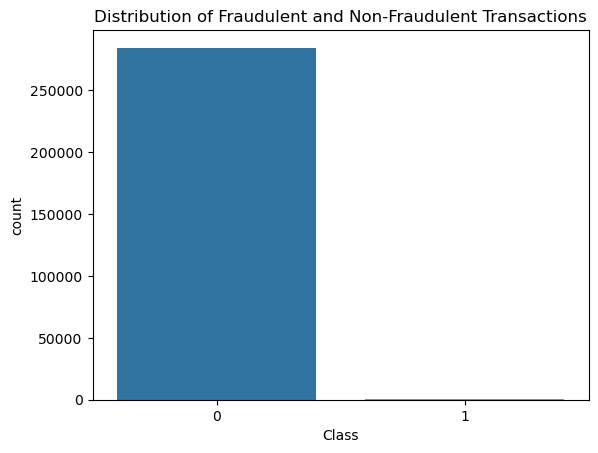

In [3]:
# Data Visualization
sns.countplot(x='Class', data=data)
plt.title('Distribution of Fraudulent and Non-Fraudulent Transactions')
plt.show()

This visualization is very helpful as we can now see the balance the data has. In this instance, a very small number of transactions are in "Class 1" which is used to denote the cases of fraudulent transactions.

#### Correlation Matrix

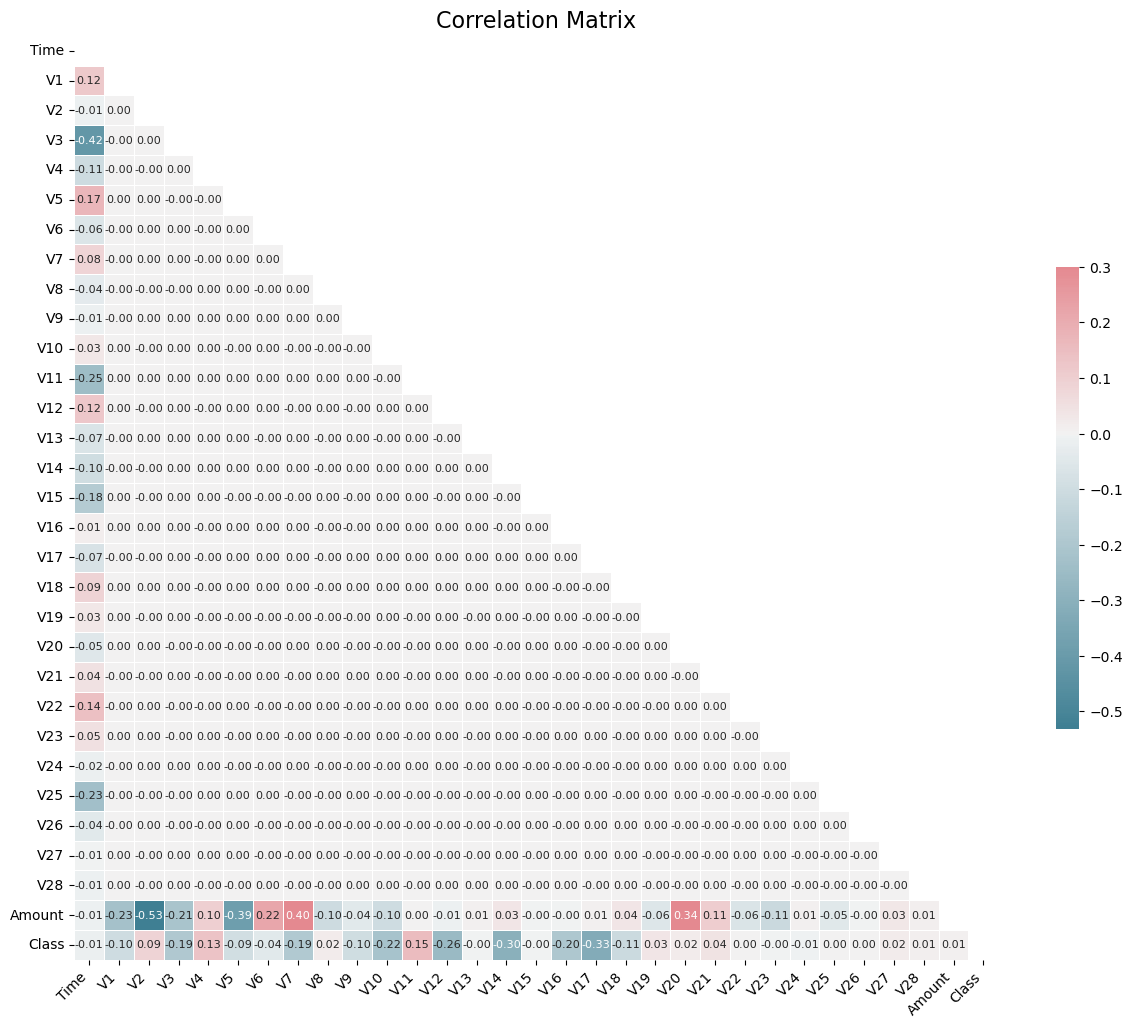

In [4]:
# Correlation Matrix
corr = data.corr()

# Set up the matplotlib figure
plt.figure(figsize=(15, 12))

# Generate a mask for the upper triangle
mask = np.triu(np.ones_like(corr, dtype=bool))

# Set up the color palette
cmap = sns.diverging_palette(220, 10, as_cmap=True)

# Draw the heatmap with the mask and correct aspect ratio
sns.heatmap(corr, mask=mask, cmap=cmap, vmax=.3, center=0,
            square=True, linewidths=.5, annot=True, fmt=".2f", 
            cbar_kws={"shrink": .5}, annot_kws={"size": 8})

# Rotate the x and y labels
plt.xticks(rotation=45, ha='right', fontsize=10)
plt.yticks(fontsize=10)

plt.title('Correlation Matrix', fontsize=16)
plt.show()

With some adjustment to the standard format to allow for the sheer amount of information we need to ingest, the correlation matrix above allows us a view into which of the fields seem to have a strong affinity for each other.

In this instance, we can see that time between transactions and amount of many spent seem to have the strongest relation to each other and the various post PCA features.

In [5]:
# Outlier Detection
# Using IQR to detect outliers in specific features
Q1 = data.quantile(0.25)
Q3 = data.quantile(0.75)
IQR = Q3 - Q1
outliers = data[((data < (Q1 - 1.5 * IQR)) |(data > (Q3 + 1.5 * IQR))).any(axis=1)]
print(f"Number of outliers detected: {outliers.shape[0]}")

Number of outliers detected: 138488


Let's perform some very quick data transformation to get rid of the outliers we've found. Since we have so much data, the large number of outliers should not cause too much of an impact but it would be better for the various models to be consistent in their performance without them.

In [6]:
# Data Cleaning and Transformation
# Scaling features for models like SVM
scaler = StandardScaler()
data_scaled = pd.DataFrame(scaler.fit_transform(data.drop('Class', axis=1)), columns=data.columns[:-1])

### Model: Training and Evaluation

With outliers cleaned up and the data understood, we can move on to the actual training of our model and some evalutions and hypertuning to get the best result

In [7]:
# Model Training and Evaluation
X = data_scaled
y = data['Class']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)

Our model will be using the Random Forest Classifier to attempt to learn the data and properly find the fraudulent charges. The reasons for using it are it's robustness against overfitting and the ability to handle a large number of features, which our dataset has many of.

As seen in prior sections, there is also a large amount of non-fraudulent cases as opposed to very few fraudulent ones. This imbalance is handled well by Random Forest and its ability to easily be used for feature importance can help with fraud identification.

In [8]:
# Random Forest Classifier
rfc = RandomForestClassifier(warm_start=True)
rfc.fit(X_train, y_train)
y_pred_rfc = rfc.predict(X_test)
print("Random Forest Classification Report:")
print(classification_report(y_test, y_pred_rfc))

Random Forest Classification Report:
              precision    recall  f1-score   support

           0       1.00      1.00      1.00     85307
           1       0.93      0.80      0.86       136

    accuracy                           1.00     85443
   macro avg       0.97      0.90      0.93     85443
weighted avg       1.00      1.00      1.00     85443



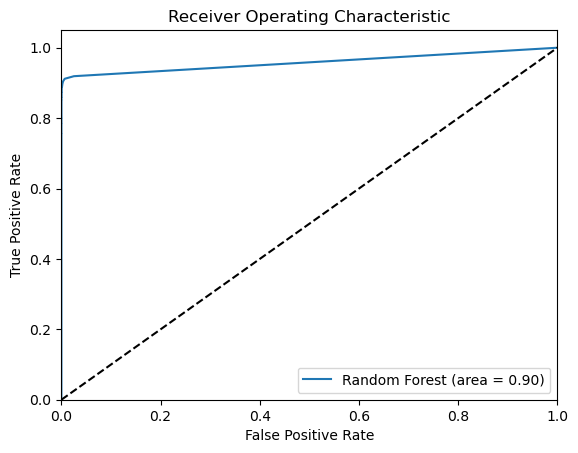

In [9]:
# ROC Curve
rfc_roc_auc = roc_auc_score(y_test, rfc.predict(X_test))
fpr, tpr, thresholds = roc_curve(y_test, rfc.predict_proba(X_test)[:,1])
plt.figure()
plt.plot(fpr, tpr, label='Random Forest (area = %0.2f)' % rfc_roc_auc)
plt.plot([0, 1], [0, 1], 'k--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic')
plt.legend(loc="lower right")
plt.show()

#### Hyperparameter Tuning

For our Hyperparameter tuning, we'll be using GridSearchCV as it is commonly used in machine learning to comprehensively and systematically find the best hyperparameters for any given model.

It tries every possible combination of the parameters we define and cross-validates them by splitting the training data into multiple "folds" and training the model on each fold and testing it ont he others. 

For efficiency's sake, GridSearchCV also sets itself to automactially run in parallel across multiple CPU cores regardless of which model is used. A very good feature for something that supports so many model types.

In [10]:
# Hyperparameter Tuning using GridSearchCV
param_grid = {
    'n_estimators': [50, 100, 200],
    'max_depth': [None, 10, 20, 30],
    'min_samples_split': [2, 5, 10],
    'min_samples_leaf': [1, 2, 4]
}
grid_rfc = GridSearchCV(estimator=rfc, param_grid=param_grid, cv=5, verbose=2, n_jobs=-1)
grid_rfc.fit(X_train, y_train)
print(f"Best parameters: {grid_rfc.best_params_}")

Fitting 5 folds for each of 108 candidates, totalling 540 fits
Best parameters: {'max_depth': None, 'min_samples_leaf': 1, 'min_samples_split': 2, 'n_estimators': 50}


In [17]:
# Use the best parameters to create the final model
best_params = grid_rfc.best_params_
final_rfc = RandomForestClassifier(**best_params)

# Fit the final model on the entire training dataset
final_rfc.fit(X_train, y_train)

# Predict on the test set
y_pred = final_rfc.predict(X_test)

print("Accuracy:", accuracy_score(y_test, y_pred))
print("Classification Report:\n", classification_report(y_test, y_pred))
print("Confusion Matrix:\n", confusion_matrix(y_test, y_pred))

Accuracy: 0.999602073897218
Classification Report:
               precision    recall  f1-score   support

           0       1.00      1.00      1.00     85307
           1       0.93      0.82      0.87       136

    accuracy                           1.00     85443
   macro avg       0.96      0.91      0.93     85443
weighted avg       1.00      1.00      1.00     85443

Confusion Matrix:
 [[85298     9]
 [   25   111]]


After hyperparameter tuing, the results aren't too much different. There's some increase in the prediction's numbers compared to the baseline model but the macro averages are practically identical.

Furthermore, the difference in accuracy is so negligible that the classification reports both rounf it to 100%.

While the tuning may have been beneficial overall, I think the amount of time and processing that went into the tuning could have been better used implementing additional models for comparison.

#### Comparison to other models

**Liner Regression**

A linear regression is a model that is often a good starting point for binary classification problems. It outputs probabilities that a given input belongs to a particular class.

In [11]:
log_reg = LogisticRegression(max_iter=1000)
log_reg.fit(X_train, y_train)
y_pred_log_reg = log_reg.predict(X_test)
print("Logistic Regression Classification Report:")
print(classification_report(y_test, y_pred_log_reg))

Logistic Regression Classification Report:
              precision    recall  f1-score   support

           0       1.00      1.00      1.00     85307
           1       0.88      0.63      0.74       136

    accuracy                           1.00     85443
   macro avg       0.94      0.82      0.87     85443
weighted avg       1.00      1.00      1.00     85443



**Support Vector Machine**

SVM is effective in high-dimensional spaces and is often used when there is a clear margin of separation between classes.

In [12]:
svm_model = SVC(kernel='rbf', probability=True)
svm_model.fit(X_train, y_train)
y_pred_svm = svm_model.predict(X_test)
print("Support Vector Machine Classification Report:")
print(classification_report(y_test, y_pred_svm))

Support Vector Machine Classification Report:
              precision    recall  f1-score   support

           0       1.00      1.00      1.00     85307
           1       0.93      0.65      0.77       136

    accuracy                           1.00     85443
   macro avg       0.96      0.83      0.88     85443
weighted avg       1.00      1.00      1.00     85443



**Gradient Boosting Classifier**

An ensemble technique that builds models sequentially, with each new model attempting to correct the errors of the previous ones. It's particularly good for complex datasets which we have after so many post-PCA features.

In [13]:
gbc = GradientBoostingClassifier()
gbc.fit(X_train, y_train)
y_pred_gbc = gbc.predict(X_test)
print("Gradient Boosting Classification Report:")
print(classification_report(y_test, y_pred_gbc))

Gradient Boosting Classification Report:
              precision    recall  f1-score   support

           0       1.00      1.00      1.00     85307
           1       0.89      0.12      0.22       136

    accuracy                           1.00     85443
   macro avg       0.95      0.56      0.61     85443
weighted avg       1.00      1.00      1.00     85443



**AdaBoost**

Another ensemble method that combines multiple weak classifiers to form a strong classifier.

In [15]:
adb = AdaBoostClassifier()
adb.fit(X_train, y_train)
y_pred_adb = adb.predict(X_test)
print("AdaBoost Classification Report:")
print(classification_report(y_test, y_pred_adb))

AdaBoost Classification Report:
              precision    recall  f1-score   support

           0       1.00      1.00      1.00     85307
           1       0.82      0.74      0.78       136

    accuracy                           1.00     85443
   macro avg       0.91      0.87      0.89     85443
weighted avg       1.00      1.00      1.00     85443



### Conclusion

In conclusion, our original Random Forest model actually out performed every other model we implemented. Most of them faired worse in their predictions though some completed much quicker on a subjective basis. Perhaps a future test could show the exact run times of each test.

The hyperparameter tuning also didn't really add much of a benefit seeing only marginal gains in scores for the sheer amount of processing time and power that it took to achieve these "optimal numbers".

As a final future step that could be taken, comparing each of these against an themselves after more feature extraction would be interesting as we could implement clustering to further add to the power of what the PCA anonymization has given us.